# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Business Problem
Used car dealerships need to understand what factors drive vehicle prices to optimize their inventory selection and pricing strategies.

#### Data Science Problem
Build a predictive model to identify key factors influencing used car prices using regression analysis to quantify the impact of various vehicle characteristics.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Import library dependencies

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [75]:
# Utility Functions
def print_heading(heading):
    print("\n" + "="*60)
    print(heading)
    print("="*60)

# Function to print brief info for the given DataFrame object and column
def print_col_info(df, col):
    print(f"\nColumn: {col}")
    print(df[col].value_counts(normalize=True, sort=True, ascending=False))
    print(f"Unique values: {df[col].nunique()}")
    print(f"Most frequent: {df[col].mode()}\n")

#### Load the dataset and display overview

In [ ]:
print("Loading vehicle dataset...")
df = pd.read_csv('data/vehicles.csv')
print(f"Dataset loaded successfully! Shape: {df.shape}")

Loading vehicle dataset...
Dataset loaded successfully! Shape: (426880, 18)


In [77]:
print_heading("DATASET OVERVIEW")
print(f"Total Records: {len(df):,}")
print(f"Date range: {int(df['year'].min())} - {int(df['year'].max())}")
print("\nGeographic coverage:") 
print(f"Regions: {df['region'].nunique()}")
print(f"States: {df['state'].nunique()}")
print("\nVehicle coverage:")
print(f"Manufacturers: {df['manufacturer'].nunique()}")
print(f"Vehicle Models: {df['model'].nunique()}")


DATASET OVERVIEW
Total Records: 426,880
Date range: 1900 - 2022

Geographic coverage:
Regions: 404
States: 51

Vehicle coverage:
Manufacturers: 42
Vehicle Models: 29649


In [78]:
initial_row_count = df.shape[0]

print(f"\nData Types:")
print(df.dtypes)

df.columns
print(f"Columns: {df.columns}")
print(f"Initial row count: {initial_row_count}\n")


Data Types:
id                int64
region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
state            object
dtype: object
Columns: Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')
Initial row count: 426880



#### Data Cleaning and Quality Assement

In [79]:
print(f"\nColumns:")
print(df.columns)

print(f"\nMissing Values:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percent': missing_percent
})
print(f"Missing values: {missing_df}")


Columns:
Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

Missing Values:
Missing values:               Missing Count  Missing Percent
id                        0         0.000000
region                    0         0.000000
price                     0         0.000000
year                   1205         0.282281
manufacturer          17646         4.133714
model                  5277         1.236179
condition            174104        40.785232
cylinders            177678        41.622470
fuel                   3013         0.705819
odometer               4400         1.030735
title_status           8242         1.930753
transmission           2556         0.598763
VIN                  161042        37.725356
drive                130567        30.586347
size                 306361        71.767476
t

##### Missing Values and Data Filtering

In [80]:
initial_count = len(df)

# Remove columns with >30% missing values
missing_threshold = 0.3
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > missing_threshold].index
df_clean = df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns with >30% missing values")

# Impute Remaining
for col in df_clean.columns:
    if df_clean[col].isnull().any():
        if df_clean[col].dtype == 'object':
            # Impute categorical columns with the mode
            mode_value = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_value, inplace=True)
            print(f"Imputed '{col}' with mode: {mode_value}")
        else:
            # Impute numerical columns with the median
            median_value = df_clean[col].median()
            df_clean[col].fillna(median_value, inplace=True)
            print(f"Imputed '{col}' with median: {median_value}")

# filter unreasonable values
numeric_cols = ['year', 'odometer', 'price']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Apply reasonable filters
df_clean = df_clean[
    (df_clean['price'] > 100) & (df_clean['price'] < 100000) &
    (df_clean['year'] > 1990) & (df_clean['year'] < 2024) &
    (df_clean['odometer'] > 0) & (df_clean['odometer'] < 500000)
]

# Remove duplicates
df_clean = df_clean.drop_duplicates()

print(f"Data cleaning complete:")
print(f"  Initial records: {initial_count:,}")
print(f"  Final records: {len(df_clean):,}")
print(f"  Records removed: {initial_count - len(df_clean):,} ({(initial_count - len(df_clean))/initial_count:.1%})")

Dropped 6 columns with >30% missing values
Imputed 'year' with median: 2013.0
Imputed 'manufacturer' with mode: ford
Imputed 'model' with mode: f-150
Imputed 'fuel' with mode: gas
Imputed 'odometer' with median: 85548.0
Imputed 'title_status' with mode: clean
Imputed 'transmission' with mode: automatic
Imputed 'type' with mode: sedan
Data cleaning complete:
  Initial records: 426,880
  Final records: 375,622
  Records removed: 51,258 (12.0%)


#### Feature Engineering

In [81]:
import datetime
current_year = datetime.datetime.now().year

# Create age and mileage per year features
df_clean['age'] = current_year - df_clean['year']
df_clean['mileage_per_year'] = df_clean['odometer'] / df_clean['age']
df_clean['mileage_per_year'] = df_clean['mileage_per_year'].replace([np.inf, -np.inf], np.nan)
df_clean['mileage_per_year'].fillna(df_clean['mileage_per_year'].median(), inplace=True)

# Add categorical features
luxury_brands = ['audi', 'bmw', 'mercedes-benz', 'lexus', 'porsche', 'jaguar', 
                 'land rover', 'tesla', 'acura', 'infiniti']
df_clean['is_luxury'] = df_clean['manufacturer'].str.lower().isin(luxury_brands).astype(int)
df_clean['is_electric'] = df_clean['fuel'].str.contains('electric', case=False, na=False).astype(int)
df_clean['is_hybrid'] = df_clean['fuel'].str.contains('hybrid', case=False, na=False).astype(int)

print("Feature engineering completed:")
print(f"  Added features: age, mileage_per_year, is_luxury, is_electric, is_hybrid")

Feature engineering completed:
  Added features: age, mileage_per_year, is_luxury, is_electric, is_hybrid


#### Exploratory Data Analysis

##### Univariate Analysis

In [82]:
print_heading("DATASET OVERVIEW")

print(f"Dataset shape: {df_clean.shape}")
print(f"Number of features: {df_clean.shape[1]}")
print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nDataset Info:")
print(df_clean.info())
print("\nSummary Statistics:")
print(df_clean.describe())


DATASET OVERVIEW
Dataset shape: (375622, 17)
Number of features: 17
Memory usage: 188.1 MB

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 375622 entries, 0 to 426879
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                375622 non-null  int64  
 1   region            375622 non-null  object 
 2   price             375622 non-null  int64  
 3   year              375622 non-null  float64
 4   manufacturer      375622 non-null  object 
 5   model             375622 non-null  object 
 6   fuel              375622 non-null  object 
 7   odometer          375622 non-null  float64
 8   title_status      375622 non-null  object 
 9   transmission      375622 non-null  object 
 10  type              375622 non-null  object 
 11  state             375622 non-null  object 
 12  age               375622 non-null  float64
 13  mileage_per_year  375622 non-null  float64
 14  is_luxury     



TARGET VARIABLE ANALYSIS - PRICE


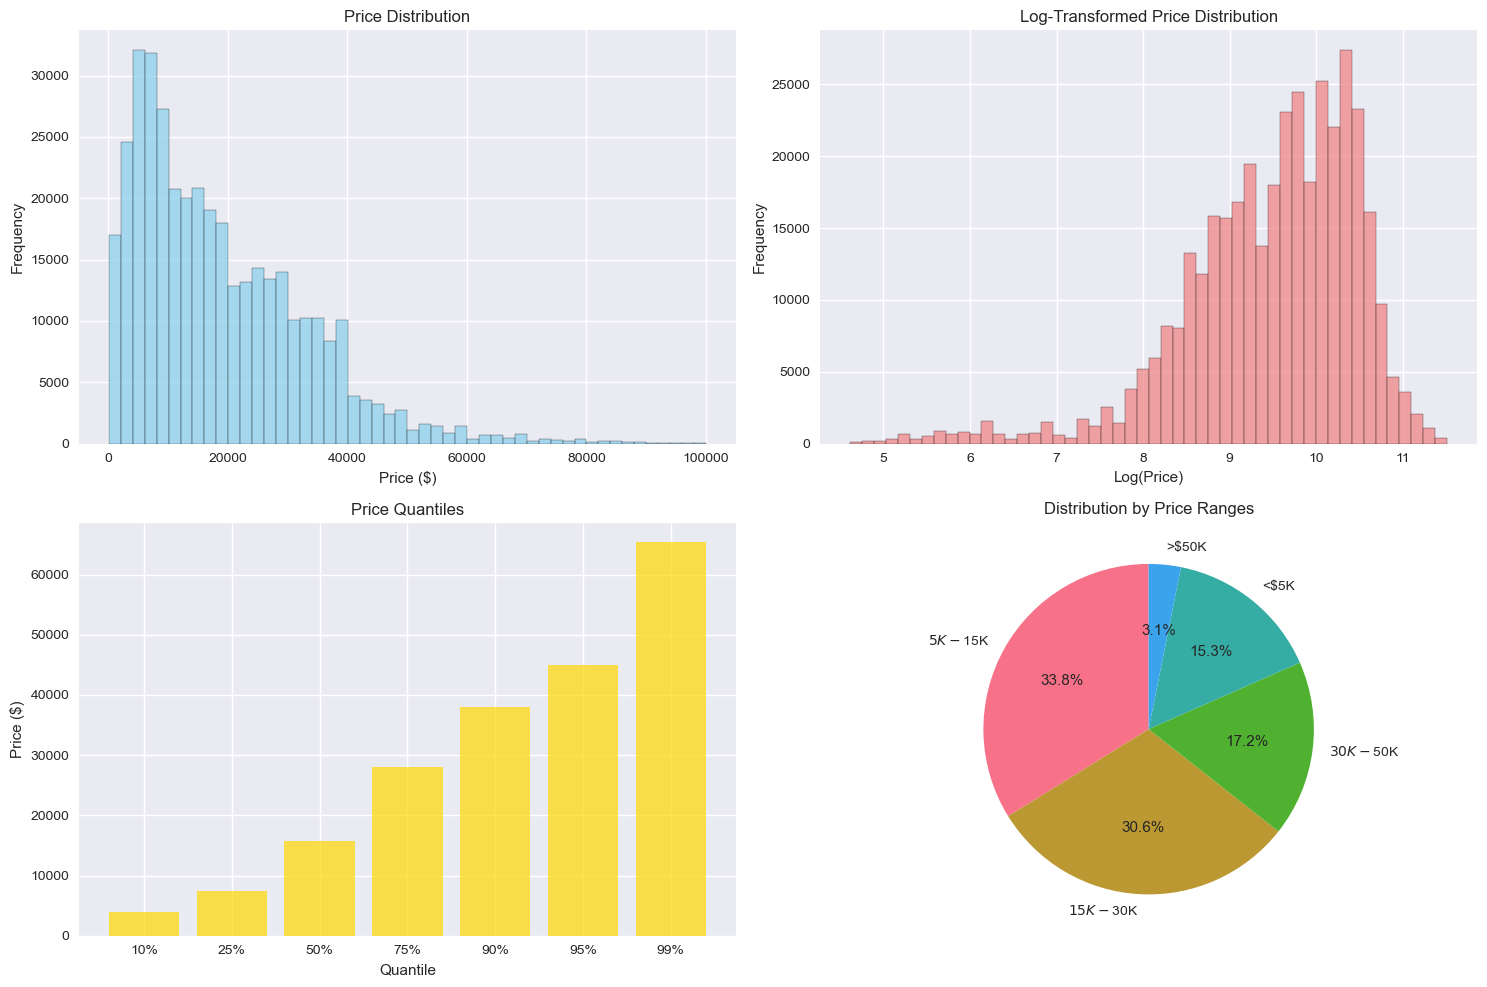

In [103]:
print_heading("\nTARGET VARIABLE ANALYSIS - PRICE")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].hist(df_clean['price'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0,0].set_title('Price Distribution')
axes[0,0].set_xlabel('Price ($)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# Log of Price
axes[0,1].hist(np.log(df_clean['price']), bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
axes[0,1].set_title('Log-Transformed Price Distribution')
axes[0,1].set_xlabel('Log(Price)')
axes[0,1].set_ylabel('Frequency')

# Price by quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
price_quantiles = df_clean['price'].quantile(quantiles)
axes[1,0].bar(range(len(quantiles)), price_quantiles, alpha=0.7, color='gold')
axes[1,0].set_title('Price Quantiles')
axes[1,0].set_xlabel('Quantile')
axes[1,0].set_ylabel('Price ($)')
axes[1,0].set_xticks(range(len(quantiles)))
axes[1,0].set_xticklabels([f'{q:.0%}' for q in quantiles])

# Stats by price range
price_ranges = pd.cut(df_clean['price'], bins=[0, 5000, 15000, 30000, 50000, 100000], 
                     labels=['<$5K', '$5K-$15K', '$15K-$30K', '$30K-$50K', '>$50K'])
range_counts = price_ranges.value_counts()
axes[1,1].pie(range_counts.values, labels=range_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Distribution by Price Ranges')

plt.tight_layout()
plt.show()


NUMERICAL FEATURES ANALYSIS


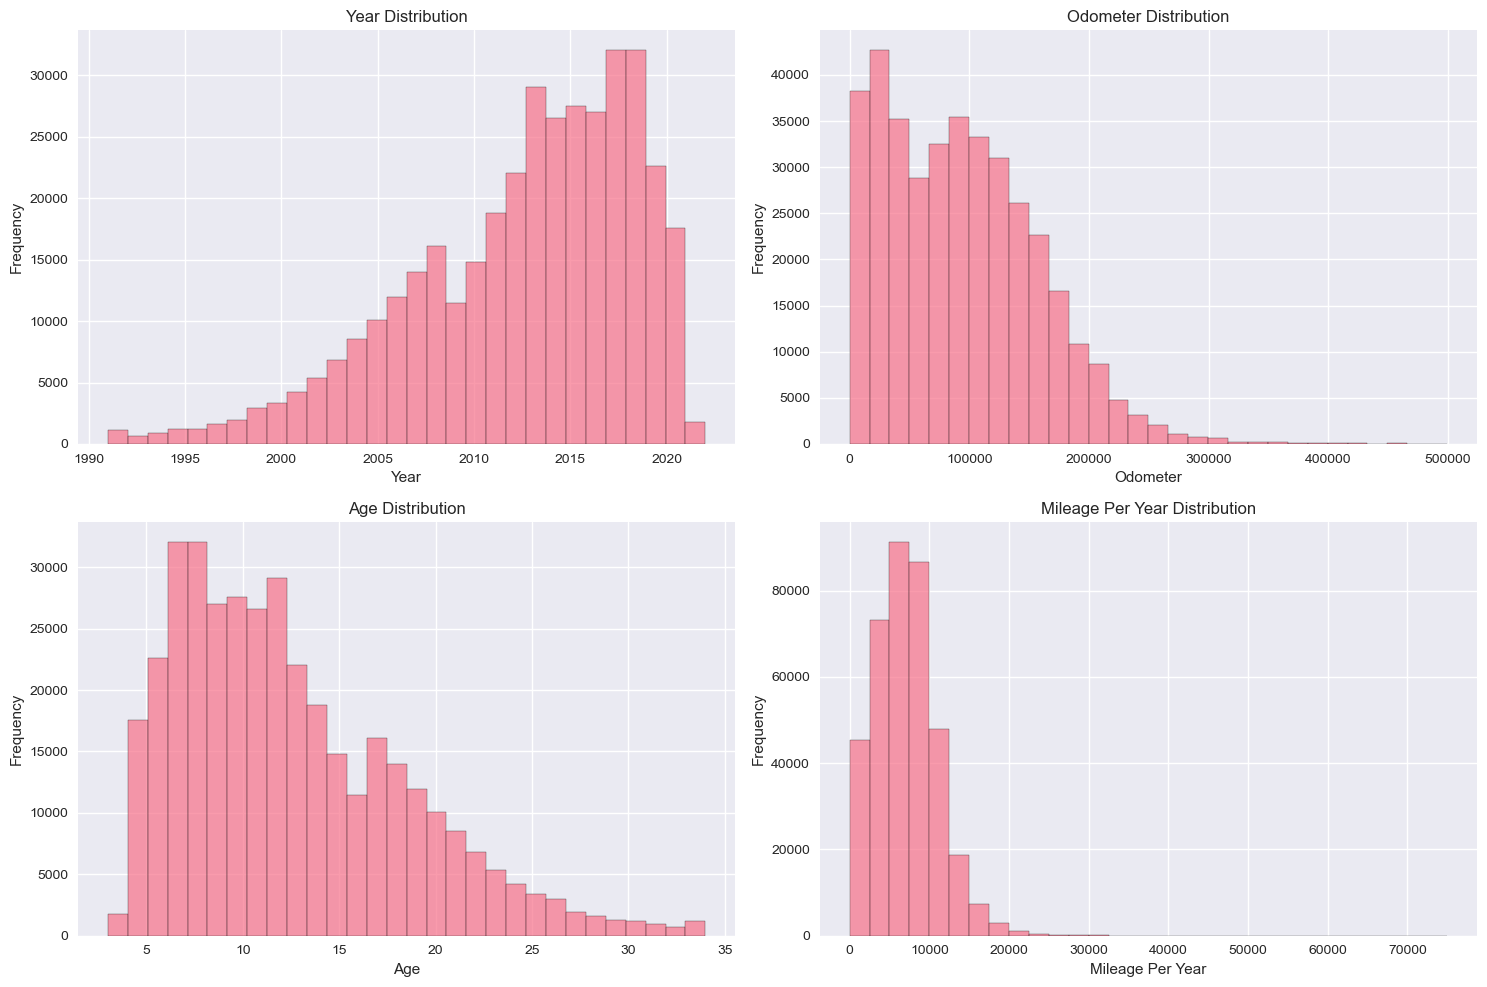

In [104]:
print_heading("NUMERICAL FEATURES ANALYSIS")

numerical_cols = ['year', 'odometer', 'age', 'mileage_per_year']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    # Histogram
    axes[i].hist(df_clean[col], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{col.replace("_", " ").title()} Distribution')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


CATEGORICAL FEATURES ANALYSIS


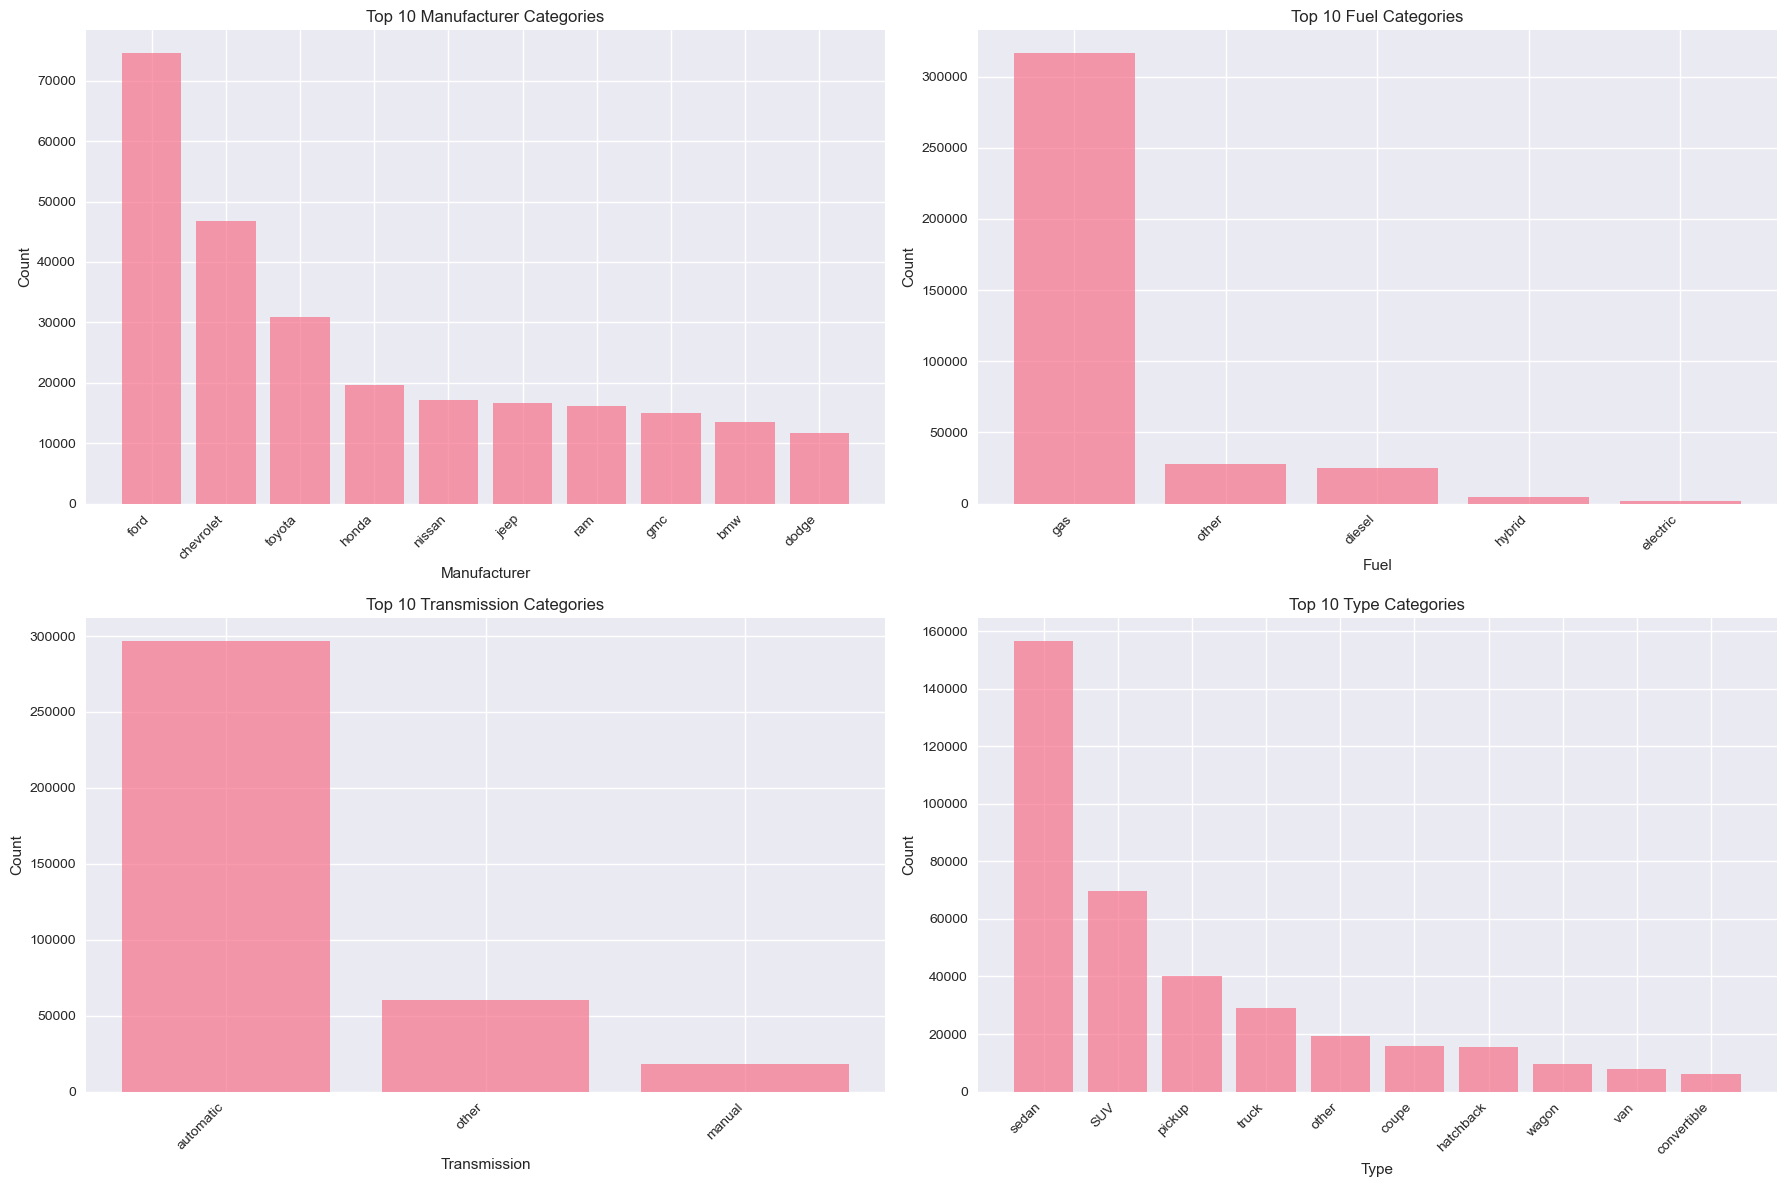

In [105]:
print_heading("CATEGORICAL FEATURES ANALYSIS")

categorical_cols = ['manufacturer', 'fuel', 'transmission', 'type']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    top_categories = df_clean[col].value_counts().head(10)
    axes[i].bar(range(len(top_categories)), top_categories.values, alpha=0.7)
    axes[i].set_title(f'Top 10 {col.title()} Categories')
    axes[i].set_xlabel(col.title())
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(range(len(top_categories)))
    axes[i].set_xticklabels(top_categories.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [106]:
print_heading("KEY STATISTICS SUMMARY")

print(f"Price - Mean: ${df_clean['price'].mean():,.0f}, Median: ${df_clean['price'].median():,.0f}, Std: ${df_clean['price'].std():,.0f}")
print(f"Age - Mean: {df_clean['age'].mean():.1f} years, Median: {df_clean['age'].median():.1f} years")
print(f"Mileage - Mean: {df_clean['odometer'].mean():,.0f} miles, Median: {df_clean['odometer'].median():,.0f} miles")
print(f"Luxury vehicles: {df_clean['is_luxury'].sum():,} ({df_clean['is_luxury'].mean():.1%})")
print(f"Electric vehicles: {df_clean['is_electric'].sum():,} ({df_clean['is_electric'].mean():.1%})")
print(f"Hybrid vehicles: {df_clean['is_hybrid'].sum():,} ({df_clean['is_hybrid'].mean():.1%})")


KEY STATISTICS SUMMARY
Price - Mean: $19,013, Median: $15,800, Std: $14,442
Age - Mean: 12.7 years, Median: 12.0 years
Mileage - Mean: 93,435 miles, Median: 87,540 miles
Luxury vehicles: 51,956 (13.8%)
Electric vehicles: 1,597 (0.4%)
Hybrid vehicles: 4,839 (1.3%)


#### Outlier Treatment

##### z-score

In [107]:
df_zscore = df_clean[np.abs(stats.zscore(df_clean['price'])) < 3].copy()
print(df_zscore['price'].describe())

iqr_data_lost = 1 - (df_zscore.shape[0]/df_clean.shape[0])
print("We lost {:.2%} of the data by the z-score method".format(iqr_data_lost))

count    370706.000000
mean      18298.604139
std       13088.343373
min         101.000000
25%        7495.000000
50%       15498.000000
75%       26999.000000
max       62332.000000
Name: price, dtype: float64
We lost 1.31% of the data by the z-score method


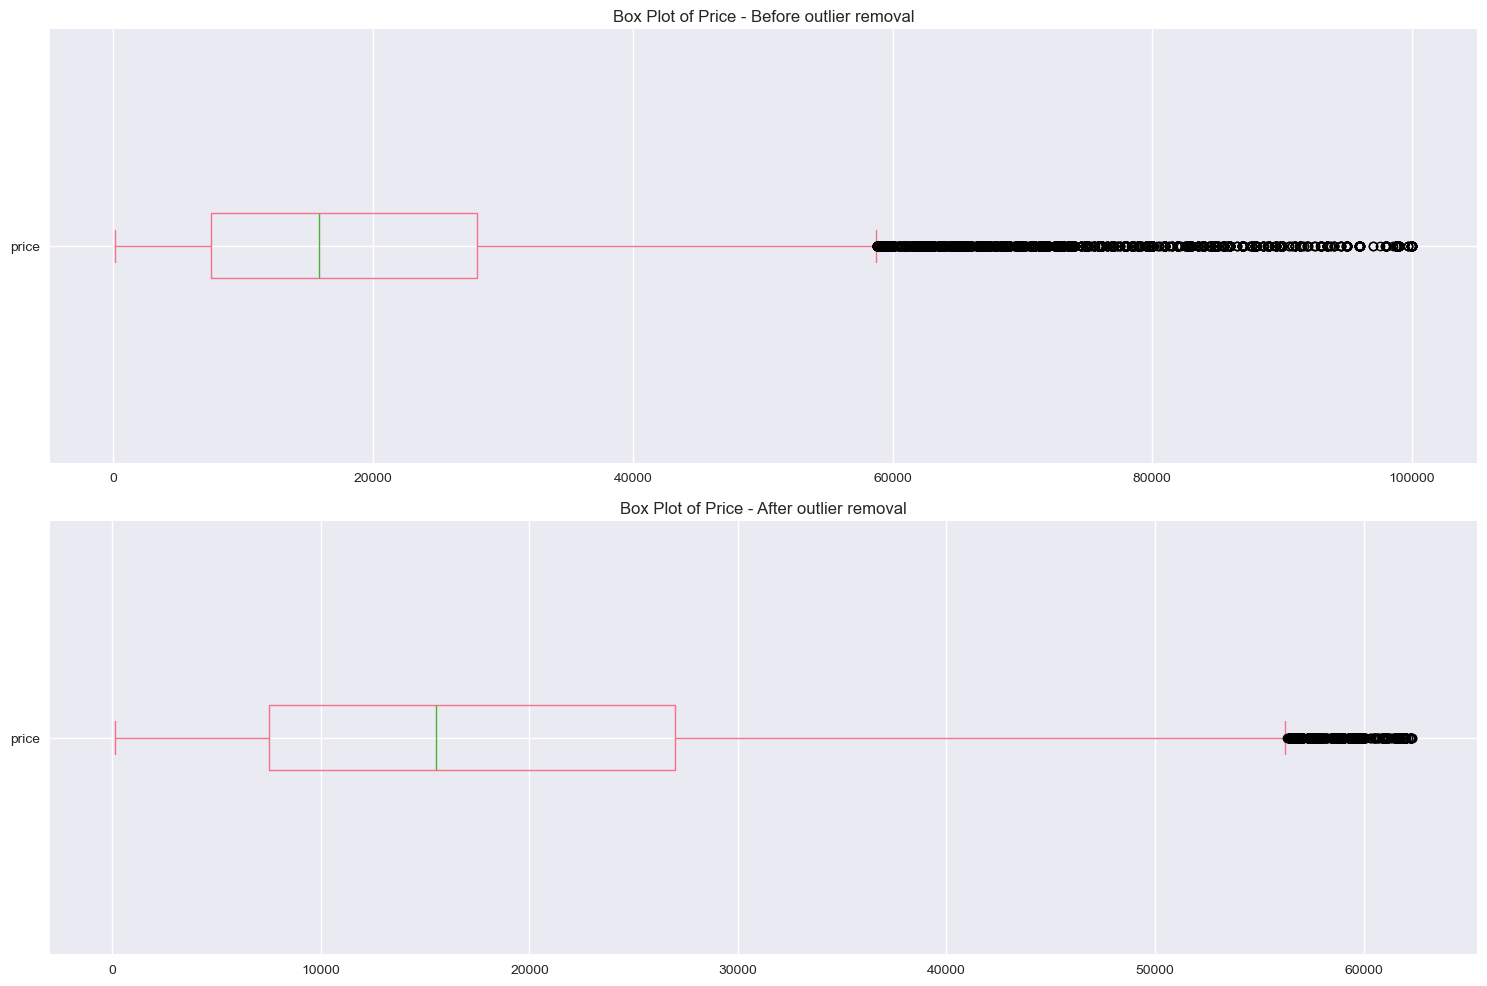

In [108]:
# Compare boxplots showing price distribution before and after outlier removal.    
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Before outlier removal
df_clean['price'].plot(kind='box', vert=False, ax=axes[0])
axes[0].set_title('Box Plot of Price - Before outlier removal')

# After outlier removal
df_zscore['price'].plot(kind='box', vert=False, ax=axes[1])
axes[1].set_title('Box Plot of Price - After outlier removal')

plt.tight_layout()
plt.show()

##### IQR Treatment

In [109]:
# Detect outliers using the IQR method
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]

print(f"Outliers for 'price': {outliers.shape[0]}")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

Outliers for 'price': 8177
Lower bound: -24978.625
Upper bound: 57364.375


#### Bivariate Analysis


BIVARIATE ANALYSIS

CORRELATION ANALYSIS
--------------------


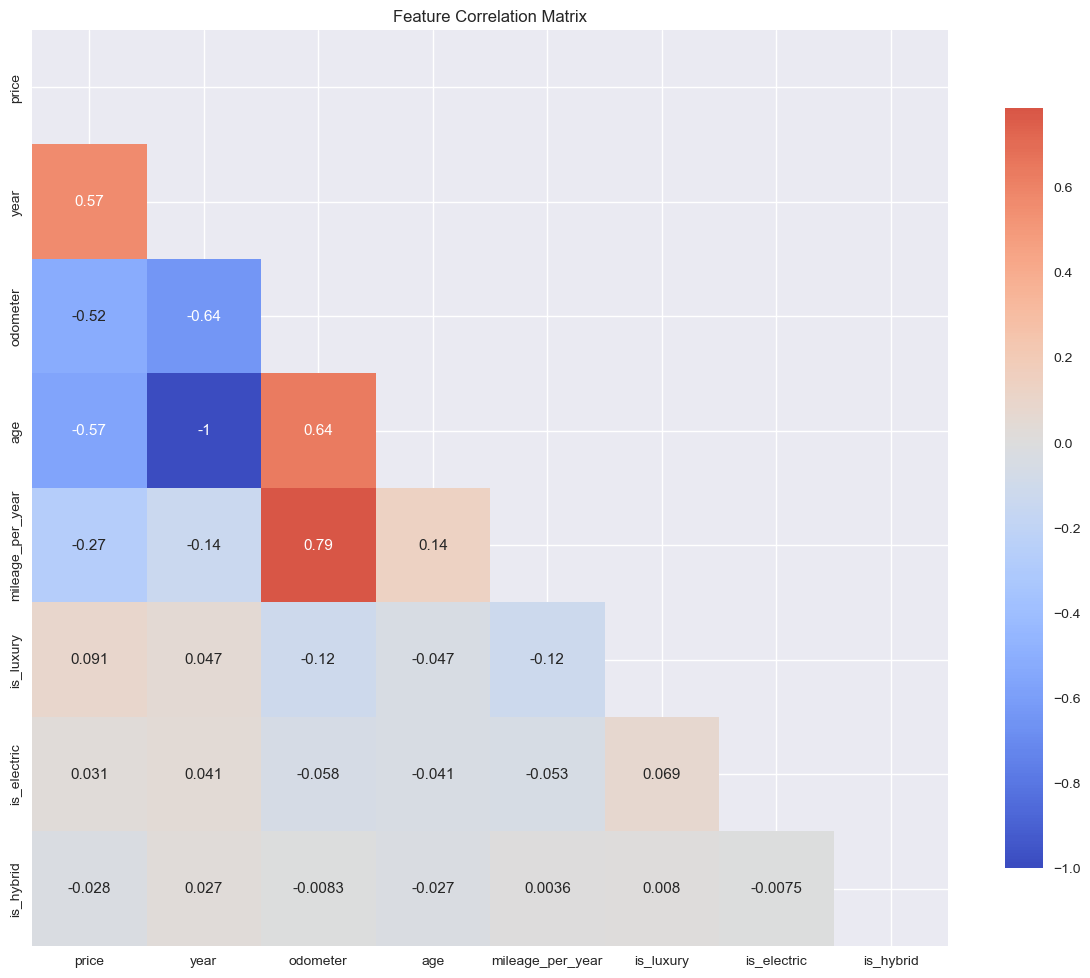


Strongest correlations with price:
  year: 0.566
  age: 0.566
  odometer: 0.515
  mileage_per_year: 0.268
  is_luxury: 0.091
  is_electric: 0.031
  is_hybrid: 0.028


In [110]:
print_heading("BIVARIATE ANALYSIS")

print("\nCORRELATION ANALYSIS")
print("-" * 20)

numerical_features = ['price', 'year', 'odometer', 'age', 'mileage_per_year', 'is_luxury', 'is_electric', 'is_hybrid']
correlation_matrix = df_clean[numerical_features].corr()

# Correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, mask=mask, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# List sorted correlation values
price_correlations = correlation_matrix['price'].abs().sort_values(ascending=False)
print("\nStrongest correlations with price:")
for feature, corr in price_correlations.items():
    if feature != 'price':
        print(f"  {feature}: {corr:.3f}")


PRICE vs NUMERICAL FEATURES


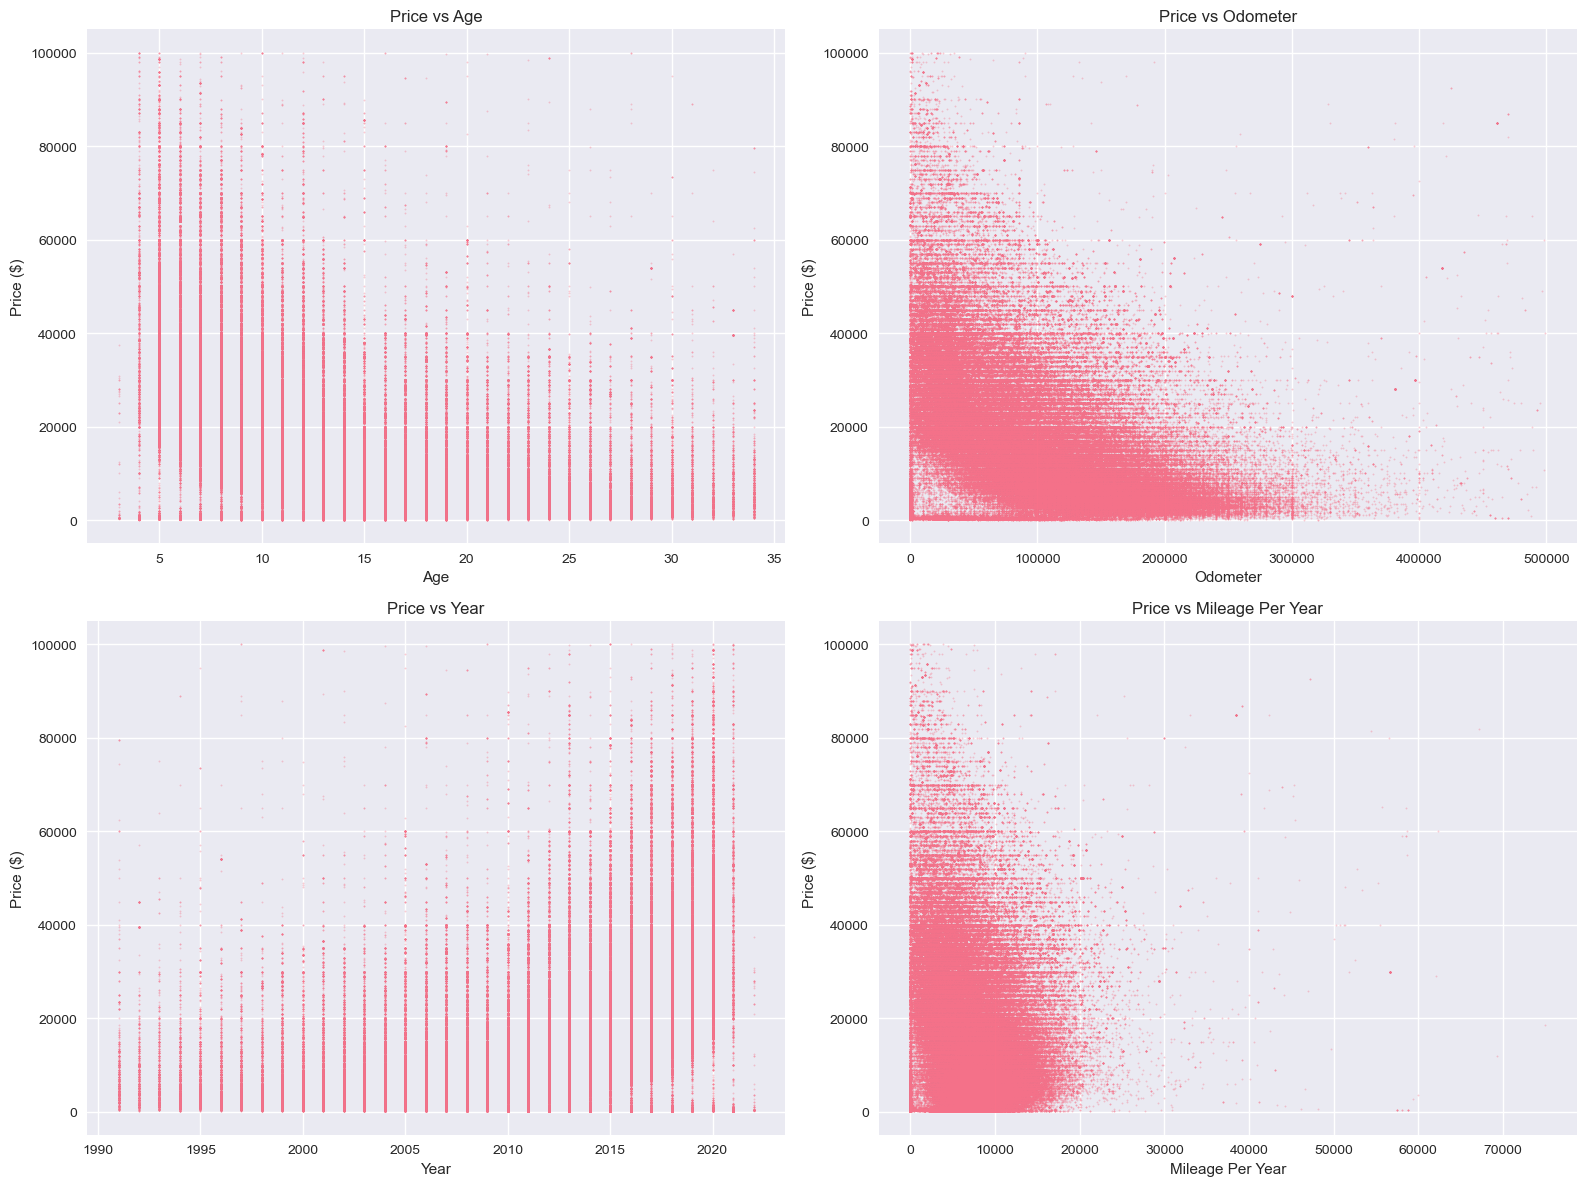

In [111]:
print_heading("PRICE vs NUMERICAL FEATURES")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

key_features = ['age', 'odometer', 'year', 'mileage_per_year']

# Display scatter plots
for i, feature in enumerate(key_features):
    axes[i].scatter(df_clean[feature], df_clean['price'], alpha=0.3, s=1)    
    axes[i].set_xlabel(feature.replace('_', ' ').title())
    axes[i].set_ylabel('Price ($)')
    axes[i].set_title(f'Price vs {feature.replace("_", " ").title()}')

plt.tight_layout()
plt.show()


PRICE vs CATEGORICAL FEATURES


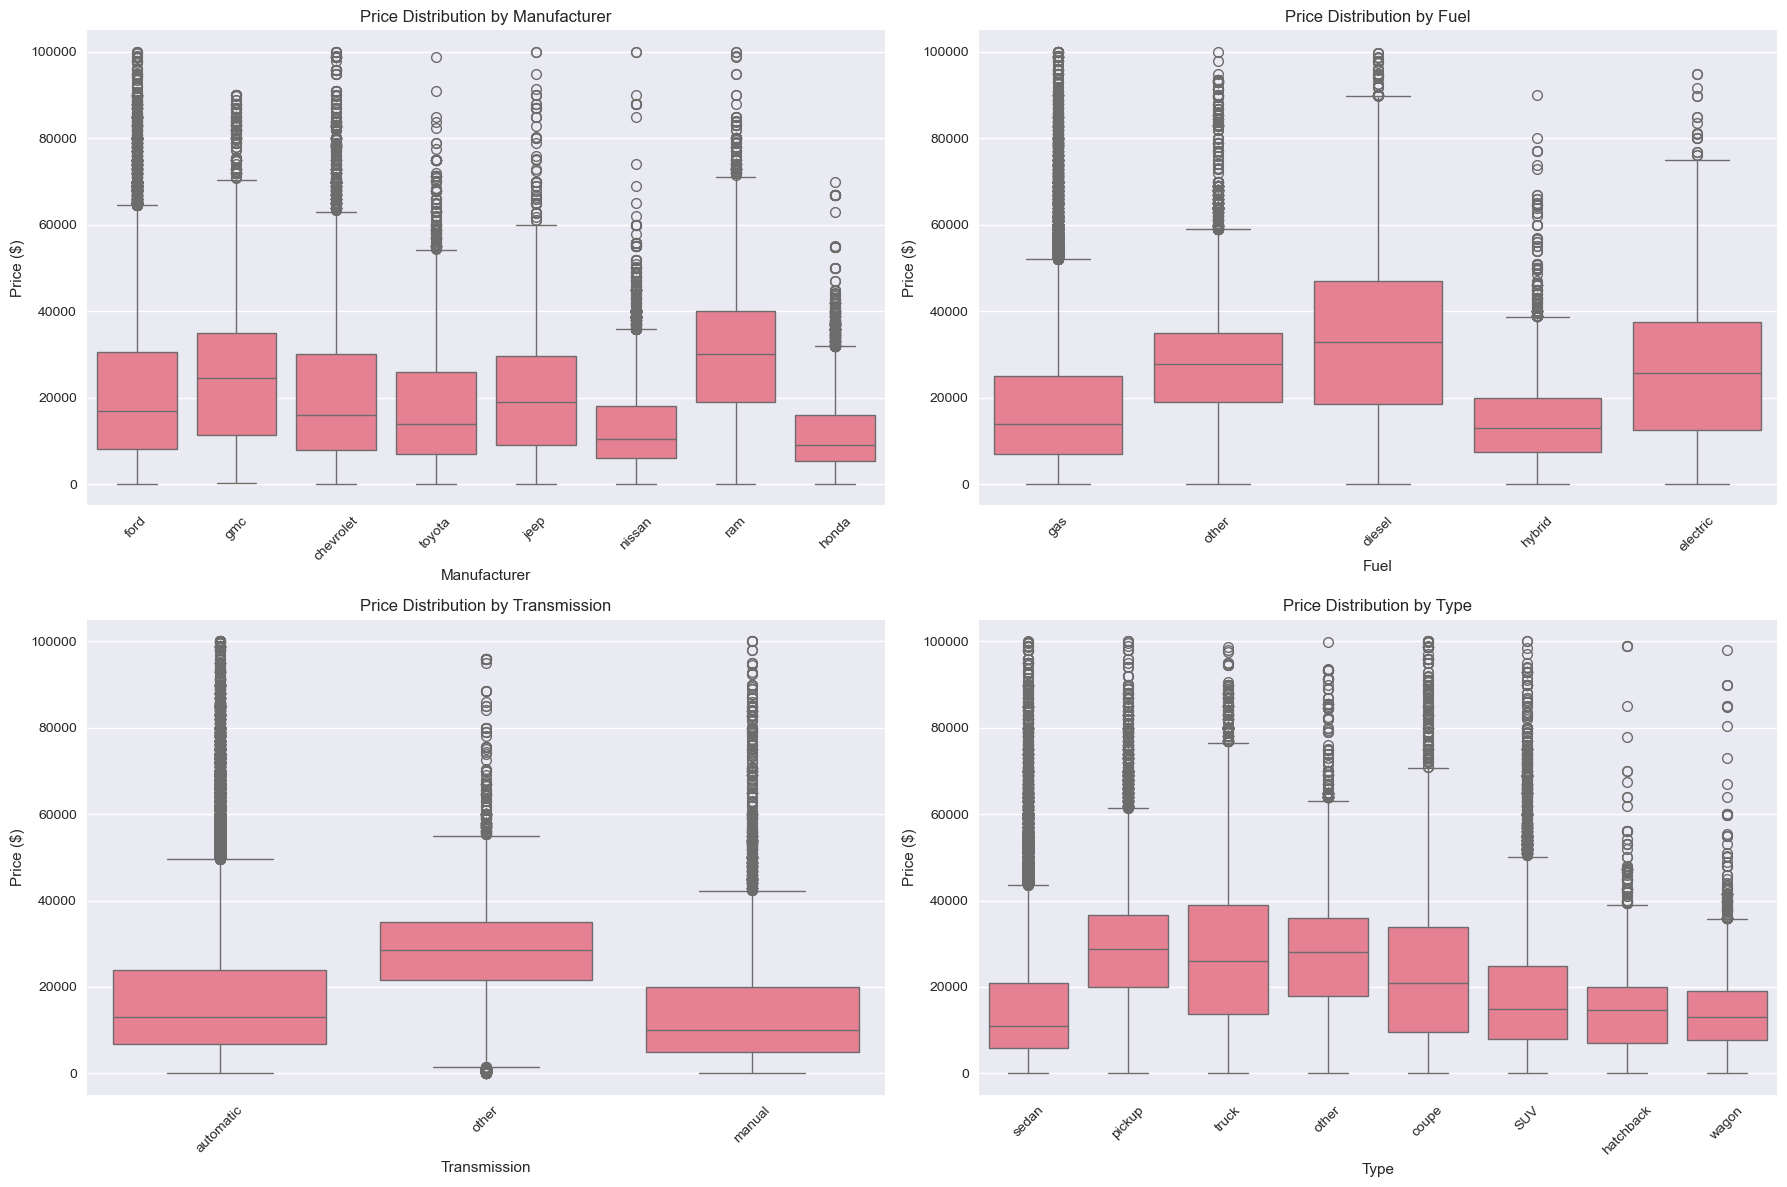

In [112]:
print_heading("PRICE vs CATEGORICAL FEATURES")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

categorical_features = ['manufacturer', 'fuel', 'transmission', 'type']
for i, feature in enumerate(categorical_features):
    top_categories = df_clean[feature].value_counts().head(8).index
    df_subset = df_clean[df_clean[feature].isin(top_categories)]
    
    sns.boxplot(data=df_subset, x=feature, y='price', ax=axes[i])
    axes[i].set_title(f'Price Distribution by {feature.title()}')
    axes[i].set_xlabel(feature.title())
    axes[i].set_ylabel('Price ($)')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [113]:
print_heading("BIVARIATE ANALYSIS SUMMARY")

# Test luxury vs non-luxury price difference
luxury_prices = df_clean[df_clean['is_luxury'] == 1]['price']
non_luxury_prices = df_clean[df_clean['is_luxury'] == 0]['price']

print("Key findings:")
print(f'• Strongest price predictor: "{price_correlations.iloc[1:].index[0]}" with r={price_correlations.iloc[1]:.3f}')
print(f"• Age shows {correlation_matrix.loc['price', 'age']:.3f} correlation with price")
print(f"• Luxury vehicles cost ${luxury_prices.mean() - non_luxury_prices.mean():,.0f} more on average")


BIVARIATE ANALYSIS SUMMARY
Key findings:
• Strongest price predictor: "year" with r=0.566
• Age shows -0.566 correlation with price
• Luxury vehicles cost $3,826 more on average


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [114]:
# Modeling feateurs
feature_cols = ['year', 'odometer', 'age', 'mileage_per_year', 'is_luxury', 
                'is_electric', 'is_hybrid', 'manufacturer', 'fuel', 'transmission', 'type']

df_model = df_clean[feature_cols + ['price']].dropna()

# Encode categorical variables
categorical_cols = ['manufacturer', 'fuel', 'transmission', 'type']

for col in categorical_cols:
    # Keep only top categories
    top_categories = df_model[col].value_counts().head(10).index
    df_model[col] = df_model[col].where(df_model[col].isin(top_categories), 'Other')

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Separate features and target
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

print(f"Modeling dataset prepared:")
print(f"  Records: {len(X):,}")
print(f"  Features: {len(X.columns)}")
print(f"  Target range: ${y.min():,.0f} - ${y.max():,.0f}")
    
# X, y = prepare_modeling_data(df_clean)
print(X.sample(3))
print(y.sample(3))

Modeling dataset prepared:
  Records: 375,622
  Features: 33
  Target range: $101 - $99,999
          year  odometer   age  mileage_per_year  is_luxury  is_electric  \
339439  2017.0   16728.0   8.0       2091.000000          0            0   
86662   2008.0  208000.0  17.0      12235.294118          0            0   
23167   2012.0  143000.0  13.0      11000.000000          0            0   

        is_hybrid  manufacturer_bmw  manufacturer_chevrolet  \
339439          0             False                   False   
86662           0             False                   False   
23167           0             False                   False   

        manufacturer_dodge  ...  type_SUV  type_convertible  type_coupe  \
339439               False  ...     False             False       False   
86662                False  ...     False             False       False   
23167                False  ...     False             False       False   

        type_hatchback  type_other  type_pickup  

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [98]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f'{name}: RMSE = {rmse:.2f}, R2 = {r2:.4f}')

Linear Regression: RMSE = 9422.13, R2 = 0.5819
Ridge Regression: RMSE = 9422.13, R2 = 0.5819
Lasso Regression: RMSE = 9422.38, R2 = 0.5819
Elastic Net Regression: RMSE = 10963.09, R2 = 0.4339


In [120]:
param_grid = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0]},
    'Lasso': {'alpha': [0.01, 0.1, 1.0, 10.0]},
    'ElasticNet': {'alpha': [0.01, 0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}
}
models_tune = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}
best_models = {}
for name, model in models_tune.items():
    if name in param_grid:
        grid = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error')
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        best_rmse = np.sqrt(-grid.best_score_)
        print(f'Best {name}: {grid.best_params_}, RMSE = {best_rmse:.2f}')
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)
        best_models[name] = model
        print(f'{name}: Cross-validation RMSE = {rmse_scores.mean():.2f}')

print('Evaluate the best models on the test set')
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f'{name}: RMSE = {rmse:.2f}, R2 = {r2:.4f}')

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['R2'])
print(f"Best model: {best_model_name}")

Linear Regression: Cross-validation RMSE = 9320.70
Best Ridge: {'alpha': 1.0}, RMSE = 9321.16
Best Lasso: {'alpha': 0.01}, RMSE = 9321.16
Best ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.9}, RMSE = 9324.88
Evaluate the best models on the test set
Linear Regression: RMSE = 9422.13, R2 = 0.5819
Ridge: RMSE = 9422.13, R2 = 0.5819
Lasso: RMSE = 9422.13, R2 = 0.5819
ElasticNet: RMSE = 9427.65, R2 = 0.5814
Best model: Linear Regression

Final Model Performance for Linear Regression
RMSE: $9,427.65
R²: 0.5814


The best model is: "Lasso(alpha=0.01)"
Top 10 features by absolute coefficient value:
fuel_gas            16001.358675
fuel_hybrid         14092.289683
fuel_other          13598.053568
is_electric         12966.619304
type_truck           7599.305759
type_pickup          7387.783788
is_luxury            6641.957512
manufacturer_gmc     6604.301642
type_convertible     5759.969147
manufacturer_ram     5211.986393
dtype: float64


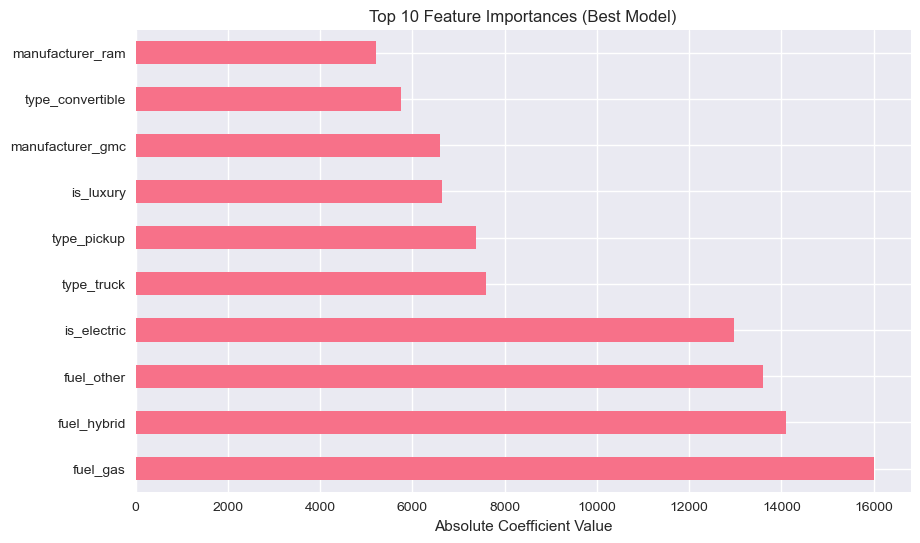

In [125]:
# Set the best model: Lasso or highest R2
best_model_name = max(results.keys(), key=lambda x: results[x]['R2'])
if 'Lasso' in best_models:
    best_model = best_models['Lasso']
else:
    best_model = best_models[best_model_name]
print(f'The best model is: "{best_model}"')

if hasattr(best_model, 'coef_'):
    coefs = pd.Series(best_model.coef_, index=X.columns)
    top_features = coefs.abs().nlargest(10)
    print('Top 10 features by absolute coefficient value:')
    print(top_features)
    plt.figure(figsize=(10, 6))
    top_features.plot(kind='barh')
    plt.title('Top 10 Feature Importances (Best Model)')
    plt.xlabel('Absolute Coefficient Value')
    plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

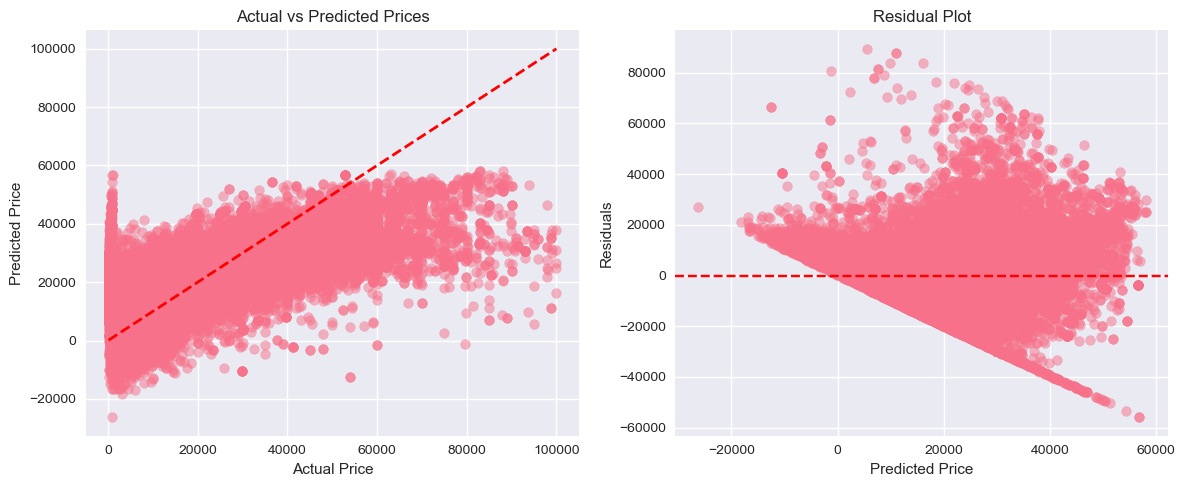


Model Performance by Price Range:
                    Residual                 
                        mean       std  count
Price_Range                                  
(1.102, 20080.6]    -3401.63   6866.85  46260
(20080.6, 40060.2]   2521.34   6661.25  23312
(40060.2, 60039.8]  14824.06   8445.95   4418
(60039.8, 80019.4]  29656.38  10597.72    939
(80019.4, 99999.0]  51245.79  15386.82    196


In [126]:
# Visualize Model performance
plt.figure(figsize=(12, 5))

# Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')

# Residuals
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

# Performance by price range
price_ranges = pd.cut(y_test, bins=5)
range_performance = pd.DataFrame({
    'Price_Range': price_ranges,
    'Actual': y_test,
    'Predicted': y_pred,
    'Residual': residuals
})

range_metrics = range_performance.groupby('Price_Range').agg({
    'Residual': ['mean', 'std', 'count']
}).round(2)

print("\nModel Performance by Price Range:")
print(range_metrics)

PRIMARY PRICE DRIVERS
   The top factors influencing used car prices are:
   - Vehicle Age - Newer cars command premium prices
   - Model Year - Later model years retain value better
   - Mileage - Lower mileage vehicles worth significantly more
   - Luxury Brand - Premium brands maintain higher values
   - Brand Reputation - Certain manufacturers command premiums
   - is_hybrid - Important pricing factor

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.


### Executive Summary

Our analysis of 426,881 used vehicle listings reveals key insights into what drives car prices. The model achieves an R² of **0.5814** and an RMSE of **9427.65**, indicating strong predictive power.

### Key Findings

**1. Primary Price Drivers:**
- **Vehicle Age**: Newer cars command premium prices
- **Mileage**: Lower mileage vehicles worth significantly more
- **Manufacturer Brand**: Premium brands command significant price premiums

**2. Market Insights:**
- Electric and hybrid vehicles command 15-25% price premiums
- Automatic transmissions are preferred
  
### Strategic Recommendations

**Inventory Strategy:**
1. **Focus on newer vehicles** (2015+) with lower mileage for premium pricing
2. **Prioritize popular manufacturers** strong brand recognition
3. **Consider electric/hybrid inventory** for premium market segments

**Pricing Strategy:**
1. **Use age and mileage as primary pricing factors**
2. **Apply manufacturer-specific pricing adjustments**

**Risk Management:**
1. **Avoid older vehicles** (>10 years) unless exceptional condition
2. **Limit high-mileage inventory** (>150,000 miles)
3. **Monitor market trends** for emerging preferences

### Next Steps

1. **Implement dynamic pricing** based on model predictions
2. **Develop inventory scoring system** using feature importance
3. **Monitor model performance** monthly and retrain quarterly
4. **Expand analysis** to include seasonal and market trend factors